# Worksheet 7 -- Clustering and Worksheet 8 -- Matrix factorization
## Orysya Stus
## 3.5.2017

In [1]:
import pandas as pd
import numpy as np
import math
import sklearn
from sklearn import metrics
from sklearn import datasets
import random
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

C:\Users\Orysya\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Worksheet 7 -- Clustering
## Part 1
For this problem, we'll be using the animals with attributes data set. Go to

    http://attributes.kyb.tuebingen.mpg.de
and, under "Downloads", choose the "base package" (the very first file in the list). Unzip it and look over the various text files.

In [2]:
!cat ./AwA-base/Animals_with_Attributes/Features/README-features.txt

   Pre-Extracted Image Features for the Animals_with_Attributes Dataset

Names and IDs of all classes are in the file 
- classes.txt

Predicate names andIDs are in the file
- predicates.txt

Training and test classnames for the attribute-based classifier are in 
- trainclasses.txt, testclasses.txt

The class<->attribute matrix is given in three formats.
- predicate-matrix-numeric.txt (positive numeric entries, some missing 
  entries encoded as -1)
- predicate-matrix-binary.txt (binarized with mean of feature, missing 
  set to 0)
- predicate-matrix.png (PNG image file for visual inspection)

Note that the entries are in the order of the names/predicates files,
*not* alphabetically.

There are 6 feature representations:

- cq: (global) color histogram (1x1 + 2x2 + 4x4 spatial pyramid, 128 bins 
      each, each histogram L1-normalized)
- lss[1]: local self similarity (2000 entry codebook, raw bag-of-visual-word 
          counts)
- phog[2]: histogram of oriented gradients (1x1 + 2x2 + 

## Part 2
This is a small data set that has information about 50 animals. The animals are listed in classes.txt. For each animal, the information consists of values for 85 features: does the animal have a tail, is it slow, does it have tusks, etc. The details of the features are in predicates.txt. The full data consists of a 50 x 85 matrix of real values, in predicate-matrix-continuous.txt. There is also a binarized version of this data, in predicate-matrix-binary.txt.

### Examine the data files.

In [3]:
!head -10 ./AwA-base/Animals_with_Attributes/classes.txt

     1	antelope
     2	grizzly+bear
     3	killer+whale
     4	beaver
     5	dalmatian
     6	persian+cat
     7	horse
     8	german+shepherd
     9	blue+whale
    10	siamese+cat


In [4]:
!head -10 ./AwA-base/Animals_with_Attributes/predicates.txt

     1	black
     2	white
     3	blue
     4	brown
     5	gray
     6	orange
     7	red
     8	yellow
     9	patches
    10	spots


In [5]:
!head -1 ./AwA-base/Animals_with_Attributes/predicate-matrix-continuous.txt

  -1.00  -1.00  -1.00  -1.00  12.34   0.00   0.00   0.00  16.11   9.19   0.00  38.09   4.44  28.55  38.75   5.68  17.07  39.99   0.00   0.00  67.08   7.78   0.00  60.24  16.80  40.59  29.70   5.56   2.47   0.00  87.43   0.00   8.64   9.04   0.00   9.23   1.23   0.00  54.58  70.86   3.33  33.56   8.15  26.14   0.00  67.85  41.19   7.36   1.11   6.94  62.32   0.00   4.44   0.00  57.76  12.63  33.24  61.86   0.00   0.00   0.00   0.00  22.72  55.81   5.90   0.00   0.00  19.88  54.79   4.94  40.97   0.00  22.32   0.00  57.14   0.00   0.00   1.23  10.49  39.24  17.57  50.59   2.35   9.70   8.38


In [6]:
!head -1 ./AwA-base/Animals_with_Attributes/predicate-matrix-binary.txt

0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0


## Part 3
Load the real-valued array, and also the animal names, into Python. Run k-means on the data (from sklearn.cluster) and ask for k = 10 clusters. For each cluster, list the animals in it. Does the clustering make sense?

### Load the data into Python.

In [7]:
samples_features = pd.read_fwf("./AwA-base/Animals_with_Attributes/predicate-matrix-continuous.txt", header=None).values
print 'The shape of the sample features is', samples_features.shape

The shape of the sample features is (50L, 85L)


In [8]:
classes = pd.read_fwf('./AwA-base/Animals_with_Attributes/classes.txt', header=None)[1].values
print classes

['antelope' 'grizzly+bear' 'killer+whale' 'beaver' 'dalmatian'
 'persian+cat' 'horse' 'german+shepherd' 'blue+whale' 'siamese+cat' 'skunk'
 'mole' 'tiger' 'hippopotamus' 'leopard' 'moose' 'spider+monkey'
 'humpback+whale' 'elephant' 'gorilla' 'ox' 'fox' 'sheep' 'seal'
 'chimpanzee' 'hamster' 'squirrel' 'rhinoceros' 'rabbit' 'bat' 'giraffe'
 'wolf' 'chihuahua' 'rat' 'weasel' 'otter' 'buffalo' 'zebra' 'giant+panda'
 'deer' 'bobcat' 'pig' 'lion' 'mouse' 'polar+bear' 'collie' 'walrus'
 'raccoon' 'cow' 'dolphin']


In [9]:
feature_names=pd.read_fwf("./AwA-base/Animals_with_Attributes/predicates.txt", header=None)[1].values
classes_features = pd.DataFrame(data = samples_features, columns = feature_names)
classes_features.index = classes
classes_features.head()

,black,white,blue,brown,gray,orange,red,yellow,patches,spots,...,water,tree,cave,fierce,timid,smart,group,solitary,nestspot,domestic
antelope,-1.00,-1.00,-1.0,-1.00,12.34,0.0,0.0,0.0,16.11,9.19,...,0.00,0.00,1.23,10.49,39.24,17.57,50.59,2.35,9.70,8.38
grizzly+bear,39.25,1.39,0.0,74.14,3.75,0.0,0.0,0.0,1.25,0.00,...,7.64,9.79,53.14,61.80,12.50,24.00,3.12,58.64,20.14,11.39
killer+whale,83.40,64.79,0.0,0.00,1.25,0.0,0.0,0.0,68.49,32.69,...,79.49,0.00,0.00,38.27,9.77,52.03,24.94,15.77,13.41,15.42
beaver,19.38,0.00,0.0,87.81,7.50,0.0,0.0,0.0,0.00,7.50,...,65.62,0.00,0.00,3.75,31.88,41.88,23.44,31.88,33.44,13.12
dalmatian,69.58,73.33,0.0,6.39,0.00,0.0,0.0,0.0,37.08,100.00,...,1.25,6.25,0.00,9.38,31.67,53.26,24.44,29.38,11.25,72.71


### Ran KMeans clustering for 10 clusters.

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(samples_features)
grouping = {i:[] for i in xrange(0,10)}

for i,animal in enumerate(classes):
    grouping[kmeans.labels_[i]].append(animal)
grouping

{0: ['antelope', 'horse', 'moose', 'giraffe', 'zebra', 'deer'],
 1: ['tiger', 'leopard', 'fox', 'wolf', 'weasel', 'bobcat', 'lion'],
 2: ['killer+whale', 'blue+whale', 'humpback+whale', 'walrus', 'dolphin'],
 3: ['skunk',
  'mole',
  'hamster',
  'squirrel',
  'rabbit',
  'rat',
  'mouse',
  'raccoon'],
 4: ['dalmatian',
  'persian+cat',
  'german+shepherd',
  'siamese+cat',
  'chihuahua',
  'collie'],
 5: ['hippopotamus',
  'elephant',
  'ox',
  'sheep',
  'rhinoceros',
  'buffalo',
  'giant+panda',
  'pig',
  'cow'],
 6: ['spider+monkey', 'gorilla', 'chimpanzee'],
 7: ['bat'],
 8: ['beaver', 'seal', 'otter'],
 9: ['grizzly+bear', 'polar+bear']}

## Part 4
Now hierarchically cluster this data, using scipy.cluster.hierarchy.linkage. Choose Ward's method, and plot the resulting tree using the dendrogram method, setting the orientation parameter to 'right' and labeling each leaf with the corresponding animal name.

You will run into a problem: the plot is too cramped because the default figure size is so small. To make it larger, preface your code with the following:

    from pylab import rcParams
    rcParams['figure.figsize'] = 5,10
    
(or try a different size if this doesn't seem quite right). Does the hierarchical clustering seem sensible to you?

For reference, used: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

### Ran hierarchical clustering on the data set to compare to the results from the KMeans clustering.

In [11]:
Z = linkage(samples_features, 'ward')

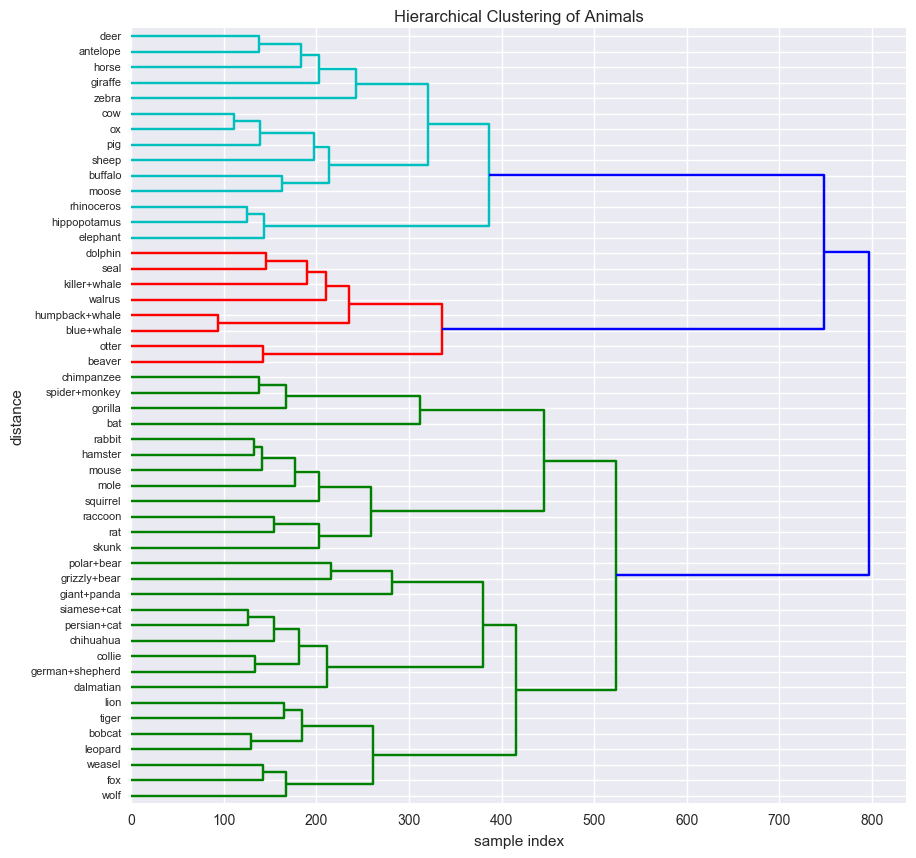

In [12]:
plt.title('Hierarchical Clustering of Animals')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, labels= classes, orientation='right')
plt.show()

### Yes, the hierarchical clustering seems sensible to me. It is easy to see which animals are most related to one another. From observation, it is interesting that the K-means clustering placed 'bat' into its own cluster, while hierarchical clustering shows that bat is most similar to gorilla, spider monkey, and chimpanzee.

# Worksheet 8 -- Matrix factorization
## Part 4
Recall the animals with attributes data set from Worksheet 7, which has information about 50 animals, each represented as a vector in R_85.

We would like to visualize these animals in 2-d. Show how to do this with a PCA projection from R_85 to R_2. Show the position of each animal, and label them with their names. (Remember from Worksheet 7 how to enlarge the figure. This time you might want to ask for size 10,10.)

Does this embedding seem sensible to you?

### Performed a PCA projection and examined the amount of variance explained when visualizing animals in 2-d

In [13]:
print 'Before PCA, data shape', samples_features.shape
pca_dg = PCA(2)
samples_features2d = pca_dg.fit_transform(samples_features)
print 'After PCA, data shape', samples_features2d.shape
print "This PCA explains", np.sum(pca_dg.explained_variance_ratio_), "of the data set's variance"

Before PCA, data shape (50L, 85L)
After PCA, data shape (50L, 2L)
This PCA explains 0.389615467763 of the data set's variance


### Repeated KMeans clustering and hierarchical clustering post PCA.

In [14]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(samples_features2d)
grouping = {i:[] for i in xrange(0,10)}

for i,animal in enumerate(classes):
    grouping[kmeans.labels_[i]].append(animal)
print 'Post PCA: '
grouping

Post PCA: 


{0: ['tiger', 'leopard', 'fox', 'wolf', 'bobcat'],
 1: ['hamster', 'rabbit', 'giant+panda', 'mouse'],
 2: ['blue+whale', 'humpback+whale', 'walrus'],
 3: ['elephant', 'ox', 'buffalo', 'pig', 'cow'],
 4: ['grizzly+bear',
  'german+shepherd',
  'siamese+cat',
  'bat',
  'chihuahua',
  'rat',
  'weasel',
  'lion',
  'raccoon'],
 5: ['beaver', 'otter', 'polar+bear'],
 6: ['dalmatian',
  'persian+cat',
  'skunk',
  'mole',
  'spider+monkey',
  'gorilla',
  'chimpanzee',
  'squirrel',
  'collie'],
 7: ['hippopotamus', 'rhinoceros'],
 8: ['killer+whale', 'seal', 'dolphin'],
 9: ['antelope', 'horse', 'moose', 'sheep', 'giraffe', 'zebra', 'deer']}

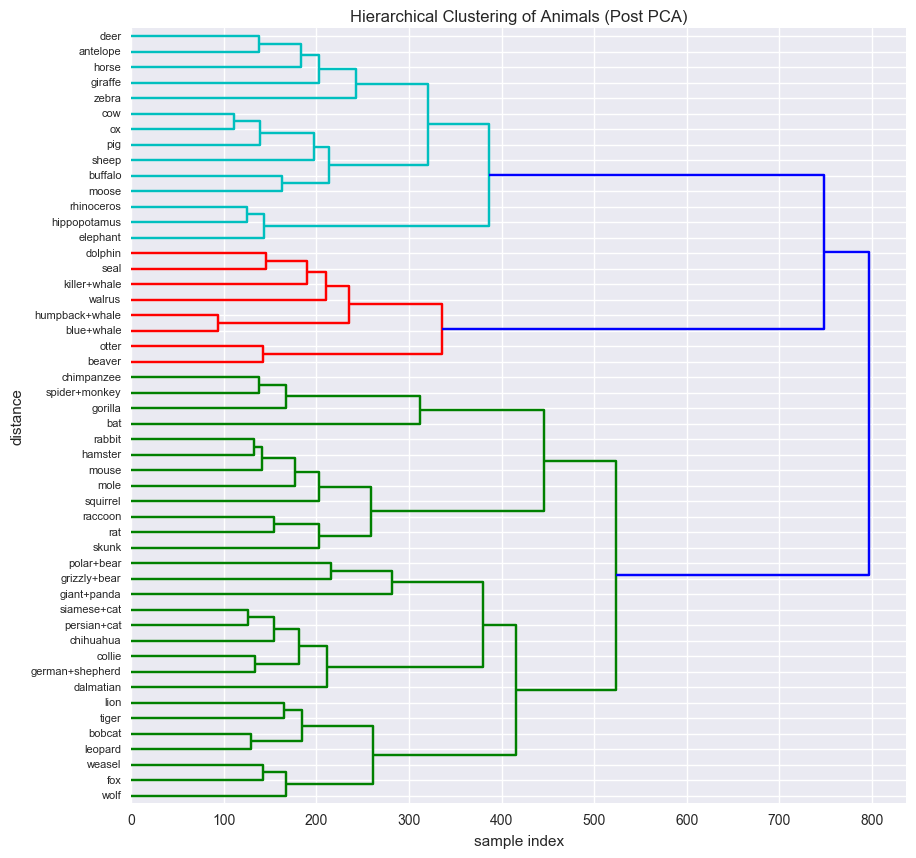

In [15]:
plt.title('Hierarchical Clustering of Animals (Post PCA)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, labels= classes, orientation='right')
plt.show()

### Visualized the position of the animals based on the PCA using a scatter plot.

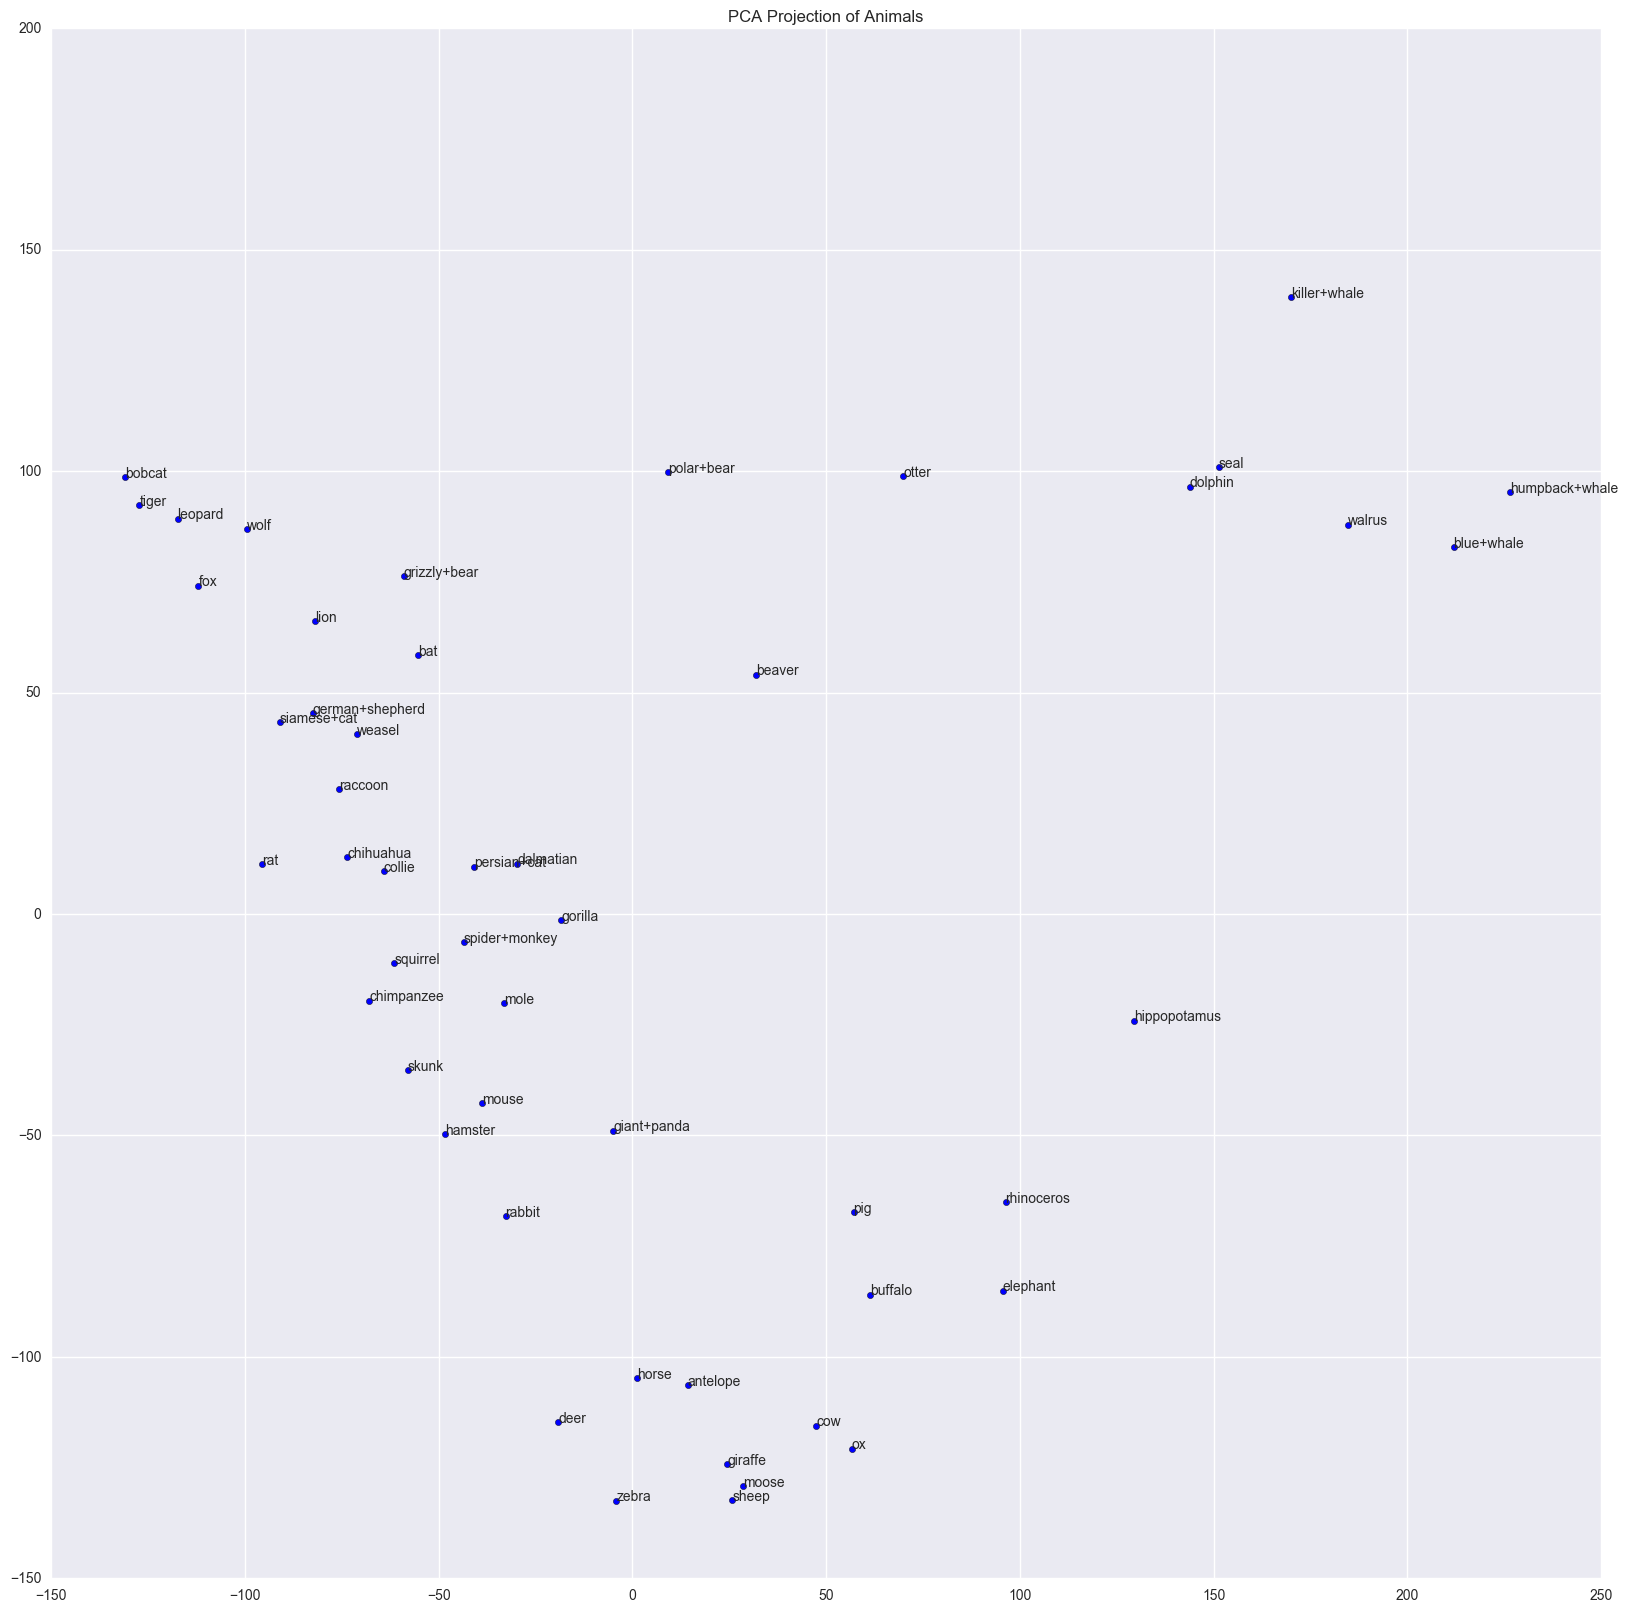

In [16]:
fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(111)
for i,point in enumerate(samples_features2d):
    ax.annotate(classes[i], xy=point, xytext=point)
    
plt.scatter(samples_features2d[:,0], samples_features2d[:,1])
plt.title('PCA Projection of Animals')

### Yes, the embedding seems sensible to me. It should be noted that the PCA projection from 85 to 2 dimensions, only explains 38.9% of the total variance.